# Creating a recommendation system for underground artists

### 1. Importing packages

In [3]:
# import packages
import spotipy as spt
import sys
import pandas as pd
from spotipy.oauth2 import SpotifyClientCredentials
from repertorio import Repertorio
import time
import ratelimit
from ratelimit import limits, sleep_and_retry
import numpy as np
from tqdm.notebook import tqdm as log_progress
import os
pd.set_option('display.max_columns', None)
import ast
import plotly.graph_objects as go
from numpy.linalg import norm
import sklearn
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import scipy
from scipy import spatial
from scipy.spatial import KDTree
from spotipy.oauth2 import SpotifyOAuth

# api access tokens
spotify_client_id = ''
spotify_client_secret = ''

# spotify client credentials
client_credentials_manager = SpotifyClientCredentials(spotify_client_id,spotify_client_secret)
sp = spt.Spotify(client_credentials_manager = client_credentials_manager)

### 2. Pulling underground playlist

In [4]:
def get_playlist_songs(playlist):
    
    track_ids = []
    track_names = []
    artist_ids = []
    artist_names = []
    release_date = []
    popularity = []
    audio_features = []
    genres = []
    
    data = sp.playlist_items(playlist)
    
    # can only pull 100 songs at once, our playlist has 2000+
    for page in range(0,data['total'] // 100+1):
        data = sp.playlist_items(playlist, limit=100, offset=100*(page))
        
        # for each song on each page, pull data
        for song_num in range(len(data['items'])):
            track_ids.append(data['items'][song_num]['track']['id'])
            track_names.append(data['items'][song_num]['track']['name'])
            artist_ids.append(data['items'][song_num]['track']['artists'][0]['id'])
            artist_names.append(data['items'][song_num]['track']['artists'][0]['name'])
            release_date.append(data['items'][song_num]['track']['album']['release_date'])
            popularity.append(data['items'][song_num]['track']['popularity'])
            # use spotify api to pull audio features
            audio_features.append(sp.audio_features(data['items'][song_num]['track']['id'])[0])
            
            
    data_track = {'name': track_names,
                  'id': track_ids,
                  'artist': artist_names,
                  'artist_id': artist_ids,
                  'popularity': popularity,
                  'release_date': release_date,
                  'audio_features': audio_features
                 }
    
    # compile dataframe
    df_track = pd.DataFrame(data_track)
    return df_track

In [5]:
# pull playlist
df_track = get_playlist_songs('spotify:playlist:3oA4eA0rwRVO1Yrig0Uijc')

In [7]:
# basic cleaning
df_track = df_track.query('popularity <=3')

In [8]:
# save to csv
output_path='obscure_tracks_3.csv'
df_track.to_csv(output_path, mode='w', header=not os.path.exists(output_path))

### 4. Expanding audio feature columns, scaling, creating neighbourhood

In [9]:
# expand audio features column
audio_features_list = ['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','type','id','uri','track_href','analysis_url','duration_ms','time_signature']
df_features = pd.DataFrame(df_track['audio_features'].tolist())
df_features = df_features.drop(['type','uri','track_href','analysis_url'],axis=1)
df_track = pd.merge(df_track,df_features,on='id',how='left')

In [10]:
# scaling
cols_to_scale = ['danceability','energy','speechiness','acousticness','instrumentalness',
                 'liveness','valence','tempo','key','loudness','mode','duration_ms']

scaler = MinMaxScaler()
df_track_fit_vec = scaler.fit(df_track[cols_to_scale])

df_track[cols_to_scale] = pd.DataFrame(df_track_fit_vec.transform(df_track[cols_to_scale]), columns = cols_to_scale)

In [12]:
# creating features vector
df_track['features_vector']= df_track[[
    'danceability','energy','speechiness','acousticness','instrumentalness','liveness','valence','tempo','loudness'
]].values.tolist()

df_track['features_vector_array'] = df_track['features_vector'].apply(lambda x: np.array(x))

# creating neighbourhood
neighbourhood = df_track.features_vector.values.tolist()
tree = spatial.KDTree(neighbourhood)

### 5. Pulling user top tracks & creating recommendation playlist

In [14]:
# initialize spotipy again
spu = spt.Spotify(auth_manager=SpotifyOAuth(spotify_client_id,
                                           spotify_client_secret,
                                           'http://localhost/',
                                           'user-top-read playlist-modify-private playlist-modify-public'))

In [36]:
def create_rec_playlist(username,time_range):
    
    # pull top tracks
    my_tracks = spu.current_user_top_tracks(time_range=time_range,limit=10)
    rec_tracks = []
    my_track_names = []
    rec_track_names = []
    my_track_ids = []
    my_artist_names = []

    for song_num in range(len(my_tracks['items'])):

        my_track_names.append(my_tracks['items'][song_num]['name'])
        my_track_ids.append(my_tracks['items'][song_num]['id'])
        
        my_track = pd.DataFrame(spu.audio_features(my_tracks['items'][song_num]['id']))
        my_track[cols_to_scale] = pd.DataFrame(df_track_fit_vec.transform(my_track[cols_to_scale]), 
                                               columns = cols_to_scale)
        # pull recommended underground tracks
        rec_tracks.append(
            df_track.iloc[[
                tree.query(my_track[[
                    'danceability','energy','speechiness','acousticness',
                    'instrumentalness','liveness','valence','tempo','loudness'
                ]].values.tolist()[0])[1]
            ]]['id'].values.tolist()[0])
        
        rec_track_names.append(
            df_track.iloc[[
                tree.query(my_track[[
                    'danceability','energy','speechiness','acousticness',
                    'instrumentalness','liveness','valence','tempo','loudness'
                ]].values.tolist()[0])[1]
            ]]['name'].values.tolist()[0])
        
    # create playlist with recommended tracks
    a = spu.user_playlist_create(username,
                                 name='undergroundify - '+time_range,
                                 public=True,
                                 collaborative=False,
                                 description='your recommended underground tracks')
        
    spu.playlist_add_items(a['id'],rec_tracks)
    
    
    # table of why recommendations were provided
    data = {'your_tracks': my_track_names, 'new_tracks': rec_track_names}
    df_recs = pd.DataFrame(data)
    return df_recs

In [37]:
# time_range = ['short_term','medium_term','long_term']
create_rec_playlist('emmajane1111','long_term')

,your_tracks,new_tracks
0,Bygones,Moonless Nights
1,Bathroom Light,Hopes & Little Jokes
2,Hit 'Em Up - Single Version,Final Decay
3,Time Comes in Roses,Little Sparrow
4,seven,Kill Our Friends
5,Can't Get Enough,Where There is Light
6,Hate It Or Love It,Maserati
7,Closer to You,Que Bonita
8,Small Hands,Due tulipani
9,right where you left me - bonus track,Rockin'


# Appendix ideas:
### Pulling artist genre information 
Only recommend songs which are in the same genre as top tracks

Issue: way too many hyper-specific genres to get a wide range. Even taking head genres doesn't really work since so many (techno, dance, electronica) are extremely similar. 

In [29]:
distinct_artists = df_track.artist_id.unique().tolist()

artist_list = []
genre_list = []

def artist_analysis(artist_id_list):
    
    for artist_id in artist_id_list:
        artist = sp.artist(artist_id)
        for num_genre in range(len(artist['genres'])):
            artist_list.append(artist_id)
            genre_list.append(artist['genres'][num_genre])
    
    data = {'artist_id': artist_list, 'genre': genre_list}
    df_genres = pd.DataFrame(data)
    return df_genres

In [ ]:
#df_genres = artist_analysis(distinct_artists)
#df_genres_all = pd.merge(df_track, df_genres, on='artist_id', how='left')

genres_list = ['pop','rock','blues','shoegaze','metal','dance','experimental','alternative','country','hip hop','rap','r&b','folk','latin','soul','indie','jazz','techno','electronic','hardcore','punk']
for genre in genres_list:
    df_genres_all[genre] = df_genres_all['genre'].str.contains(genre).astype(int)


<AxesSubplot: title={'center': 'Genre Distribution'}, ylabel='genre'>

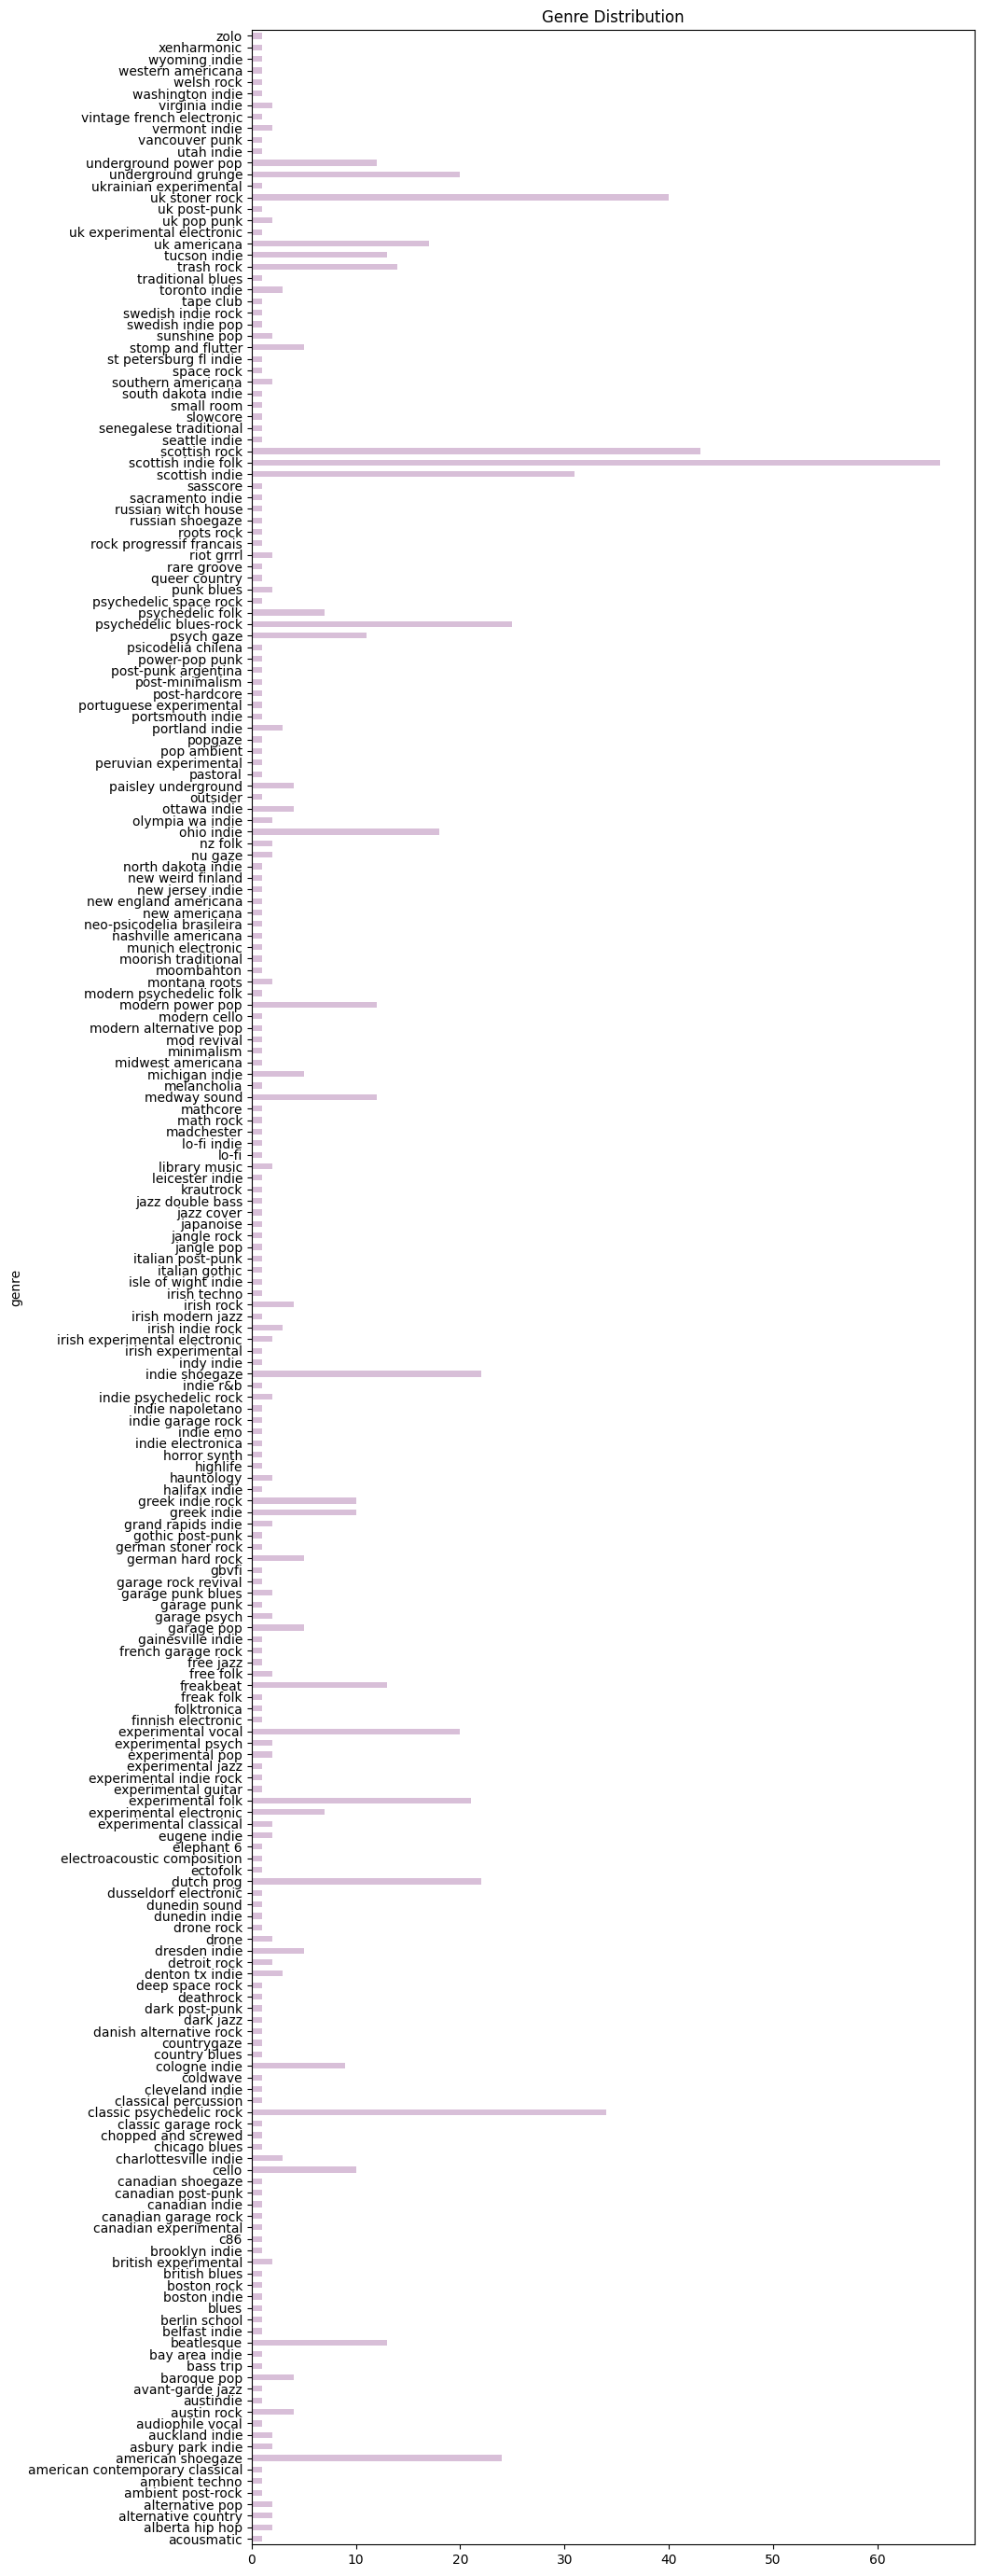

In [35]:
df_genres_all.groupby(['genre']).size().plot(kind='barh',figsize=(10,35),color='thistle',title='Genre Distribution')

### View genre of input song vs. genre of recommended song
Could provide cool overall view of how genres differ across recommendations

### Output radar graph with input vs. recommendation

In [42]:
my_tracks = spu.current_user_top_tracks(time_range='long_term',limit=10)
my_track = pd.DataFrame(spu.audio_features(my_tracks['items'][0]['id']))
my_track[cols_to_scale] = pd.DataFrame(df_track_fit_vec.transform(my_track[cols_to_scale]), 
                                               columns = cols_to_scale)

In [43]:
my_track

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.300104,0.161792,0.0,0.459642,1.0,0.042667,0.921529,0.100811,0.385103,0.099898,0.383483,audio_features,6vB6RKkbDwNoou9ap8JLGm,spotify:track:6vB6RKkbDwNoou9ap8JLGm,https://api.spotify.com/v1/tracks/6vB6RKkbDwNo...,https://api.spotify.com/v1/audio-analysis/6vB6...,0.290127,4


In [45]:
import plotly.graph_objects as go

categories = [
    'danceability','energy','speechiness','acousticness','instrumentalness','liveness','valence','tempo','loudness'
]

song = sp.audio_features()

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=my_track[[
                    'danceability','energy','speechiness','acousticness',
                    'instrumentalness','liveness','valence','tempo','loudness'
                ]].values.tolist()[0],
      theta=categories,
      fill='toself',
      name='Bygones',
    fillcolor = 'grey',
    opacity = 0.6
))

fig.add_trace(go.Scatterpolar(
      r = df_track.query('name == "Moonless Nights"')['features_vector'].values.tolist()[0],
      theta=categories,
      fill='toself',
      name='Moonless Nights',
    fillcolor = 'orange',
    opacity = 0.6
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=False,
      range=[-0.4, 1]
    )),
  showlegend=True,
    title = {
         'text': "Audio features analysis",
         'y':0.95, # new
         'x':0.5,
         'xanchor': 'center',
         'yanchor': 'top' # new
        }
)

fig.show()

### Only using acousticness, energy, tempo variables